## Installing Kaggle and Downloading Ethereum Fraud Detection Dataset

The code `!pip install kaggle` will install the Kaggle API on the computer. To run the this cell you will need to provide the Kaggle user and password in json format in the same directory of this notebook. Please follow the tutorial available in the Further Reading section at the end of the Chapter. 
The code `!mkdir ~/.kaggle` will create a directory called `.kaggle` in the user's home directory, `!cp kaggle.json ~/.kaggle/` copy the `kaggle.json` file to the `.kaggle` directory and `!chmod 600 ~/.kaggle/kaggle.json` sets the permissions of the `kaggle.json` file to read-only. 

With `!kaggle datasets download vagifa/ethereum-frauddetection-dataset` download the Ethereum Fraud Detection Dataset from Kaggle and with `!unzip ethereum-frauddetection-dataset.zip` unzip it for use. 

In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download vagifa/ethereum-frauddetection-dataset
!unzip ethereum-frauddetection-dataset

  0% 0.00/923k [00:00<?, ?B/s]
100% 923k/923k [00:00<00:00, 119MB/s]
Archive:  ethereum-frauddetection-dataset.zip
  inflating: transaction_dataset.csv  


## Imports

Import the necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras import Input
import tensorflow as tf
import keras

## Read the Dataset

Define a list of columns to be used and read the dataset from the file `transaction_dataset.csv` downloaded from Kaggle. 

In [2]:
columns=['FLAG', 'Avg min between received tnx','Sent tnx', 'Received Tnx', 'Unique Received From Addresses',
        'avg val received','avg val sent', 'total transactions (including tnx to create contract','total Ether sent', 'total ether received',
      ' Total ERC20 tnxs', ' ERC20 total Ether received']
df= pd.read_csv ("transaction_dataset.csv", usecols=columns)
df.head()

,FLAG,Avg min between received tnx,Sent tnx,Received Tnx,Unique Received From Addresses,avg val received,avg val sent,total transactions (including tnx to create contract,total Ether sent,total ether received,Total ERC20 tnxs,ERC20 total Ether received
0,0,1093.71,721,89,40,6.589513,1.200681,810,865.691093,586.466675,265.0,3.558854e+07
1,0,2958.44,94,8,5,0.385685,0.032844,102,3.087297,3.085478,8.0,4.034283e+02
2,0,2434.02,2,10,10,0.358906,1.794308,12,3.588616,3.589057,8.0,5.215121e+02
3,0,15785.09,25,9,7,99.488840,70.001834,34,1750.045862,895.399559,14.0,1.711105e+04
4,0,10707.77,4598,20,7,2.671095,0.022688,4619,104.318883,53.421897,42.0,1.628297e+05


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9841 entries, 0 to 9840
Data columns (total 12 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   FLAG                                                  9841 non-null   int64  
 1   Avg min between received tnx                          9841 non-null   float64
 2   Sent tnx                                              9841 non-null   int64  
 3   Received Tnx                                          9841 non-null   int64  
 4   Unique Received From Addresses                        9841 non-null   int64  
 5   avg val received                                      9841 non-null   float64
 6   avg val sent                                          9841 non-null   float64
 7   total transactions (including tnx to create contract  9841 non-null   int64  
 8   total Ether sent                                      9841

## Dropping Null Values

Drop all rows with null values in the specified columns.

In [4]:
df.dropna(subset=['Avg min between received tnx',
       'Sent tnx', 'Received Tnx', 'Unique Received From Addresses',
       'avg val received', 'avg val sent',
       'total transactions (including tnx to create contract',
       'total Ether sent', 'total ether received', ' Total ERC20 tnxs',
       ' ERC20 total Ether received'], inplace=True)


## Dependent and independent variables

The `X` variable contains all the columns from the dataframe except for the `FLAG` column, while the `y` variable contains only the `FLAG` column also known as labels. 

In [5]:
X = df.loc[:, df.columns != "FLAG"]
y= df[['FLAG']]

## Scaling Data

Create a RobustScaler object. The `X=scaler.fit_transform(X)` will use the RobustScaler object to scale the data in the `X` variable. This scaling will help ensure that all the features in the data have the same range, which can help improve the accuracy of the model. 

In [6]:
scaler = RobustScaler()
X=scaler.fit_transform(X)

## Splitting Data

Split the data into training and testing sets. The `stratify` parameter ensures that the proportion of labels in the training and testing sets is the same as the proportion of labels in the original dataset.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify= y)

In [8]:
print (X_train.shape)
print (y_train.shape)

print (X_test.shape)
print (y_test.shape)

(6038, 11)
(6038, 1)
(2974, 11)
(2974, 1)


## Build the Model

Create a Sequential model with four layers, the first layer taking the shape of the training data, and the last layer having a sigmoid activation function. Compile the model by defining the loss function as Binary Crossentropy and the metrics as Precision and Recall.

In [11]:
metrics = [
 #   keras.metrics.FalseNegatives(name="fn"),
 #   keras.metrics.FalsePositives(name="fp"),
 #   keras.metrics.TrueNegatives(name="tn"),
 #   keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True , reduction='sum')
#create model
model = Sequential()
#add model layers
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(30, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(1e-2), loss=loss_function, metrics=metrics)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 30)                360       
                                                                 
 dense_11 (Dense)            (None, 10)                310       
                                                                 
 dense_12 (Dense)            (None, 5)                 55        
                                                                 
 dense_13 (Dense)            (None, 1)                 6         
                                                                 
Total params: 731
Trainable params: 731
Non-trainable params: 0
_________________________________________________________________


#### Setting Class Weights

Set the class weights for the model. This is used to adjust the weights of the classes in the model to account for imbalanced datasets.
The formula for class_weight is `total observations / (number of classes * observations in class)`.

In [12]:
#class_weight={1:3.34 ,0:0.59}

## Training the Model

Train the model using the training data (X_train and y_train) and the validation data (X_test and y_test). The model will be trained for 90 epochs.

In [13]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=90)  #, class_weight=class_weight

Epoch 1/90


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


183/189 [============================>.] - ETA: 0s - loss: 501.7614 - precision: 0.8741 - recall: 0.4215

/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


189/189 [==============================] - 4s 8ms/step - loss: 486.7880 - precision: 0.8733 - recall: 0.4347 - val_loss: 7.0528 - val_precision: 0.8788 - val_recall: 0.7803
Epoch 2/90
189/189 [==============================] - 0s 2ms/step - loss: 8.1313 - precision: 0.8704 - recall: 0.7058 - val_loss: 4.9093 - val_precision: 0.8981 - val_recall: 0.7511
Epoch 3/90
189/189 [==============================] - 0s 2ms/step - loss: 4.8393 - precision: 0.8778 - recall: 0.7389 - val_loss: 4.1952 - val_precision: 0.9134 - val_recall: 0.7803
Epoch 4/90
189/189 [==============================] - 0s 2ms/step - loss: 4.3870 - precision: 0.8984 - recall: 0.7633 - val_loss: 3.9093 - val_precision: 0.9291 - val_recall: 0.7937
Epoch 5/90
189/189 [==============================] - 0s 2ms/step - loss: 5.9534 - precision: 0.8960 - recall: 0.7721 - val_loss: 3.8150 - val_precision: 0.9034 - val_recall: 0.8386
Epoch 6/90
189/189 [==============================] - 0s 2ms/step - loss: 4.2080 - precision: 0.902

## Evaluating the Model

Evaluate the model's performance over the validation data (X_test and y_test). Use the model's predictions (y_test_pred) and compare them to the actual labels (y_test). In this cell we print the accuracy score.

In [14]:
from sklearn import metrics
y_test_pred = model.predict(X_test).round()

acc = metrics.accuracy_score(y_test_pred, y_test)

print(f'Accuracy: {acc:,.2%}')

93/93 [==============================] - 0s 1ms/step
Accuracy: 96.84%


Print a `classification report` which will provide a more detailed analysis of the model's performance. It includes metrics such as `precision`, `recall`, and `f1-score`. 

In [15]:
print(classification_report(y_test_pred,y_test))

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      2584
         1.0       0.83      0.95      0.89       390

    accuracy                           0.97      2974
   macro avg       0.91      0.96      0.93      2974
weighted avg       0.97      0.97      0.97      2974



#### Confusion Matrix

Create a confusion matrix which will provide a visual representation of the model's performance. It shows the number of true positives, true negatives, false positives, and false negatives. 

<Axes: >

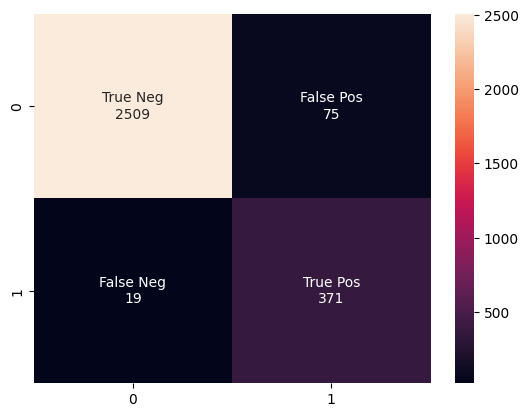

In [16]:
conf_mat=confusion_matrix(y_test_pred,y_test)
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                conf_mat.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_mat, annot=labels, fmt="")